
# Importance of Feature Scaling

Feature scaling through standardization, also called Z-score normalization, is
an important preprocessing step for many machine learning algorithms. It
involves rescaling each feature such that it has a standard deviation of 1 and a
mean of 0.

Even if tree based models are (almost) not affected by scaling, many other
algorithms require features to be normalized, often for different reasons: to
ease the convergence (such as a non-penalized logistic regression), to create a
completely different model fit compared to the fit with unscaled data (such as
KNeighbors models). The latter is demoed on the first part of the present
example.

On the second part of the example we show how Principal Component Analysis (PCA)
is impacted by normalization of features. To illustrate this, we compare the
principal components found using :class:`~sklearn.decomposition.PCA` on unscaled
data with those obatined when using a
:class:`~sklearn.preprocessing.StandardScaler` to scale data first.

In the last part of the example we show the effect of the normalization on the
accuracy of a model trained on PCA-reduced data.


In [1]:
# Author: Tyler Lanigan <tylerlanigan@gmail.com>
#         Sebastian Raschka <mail@sebastianraschka.com>
#         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
# License: BSD 3 clause

## Load and prepare data

The dataset used is the `wine_dataset` available at UCI. This dataset has
continuous features that are heterogeneous in scale due to differing
properties that they measure (e.g. alcohol content and malic acid).



In [2]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = load_wine(return_X_y=True, as_frame=True)
scaler = StandardScaler().set_output(transform="pandas")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)
scaled_X_train = scaler.fit_transform(X_train)


## Effect of rescaling on a k-neighbors models

For the sake of visualizing the decision boundary of a
:class:`~sklearn.neighbors.KNeighborsClassifier`, in this section we select a
subset of 2 features that have values with different orders of magnitude.

Keep in mind that using a subset of the features to train the model may likely
leave out feature with high predictive impact, resulting in a decision
boundary that is much worse in comparison to a model trained on the full set
of features.



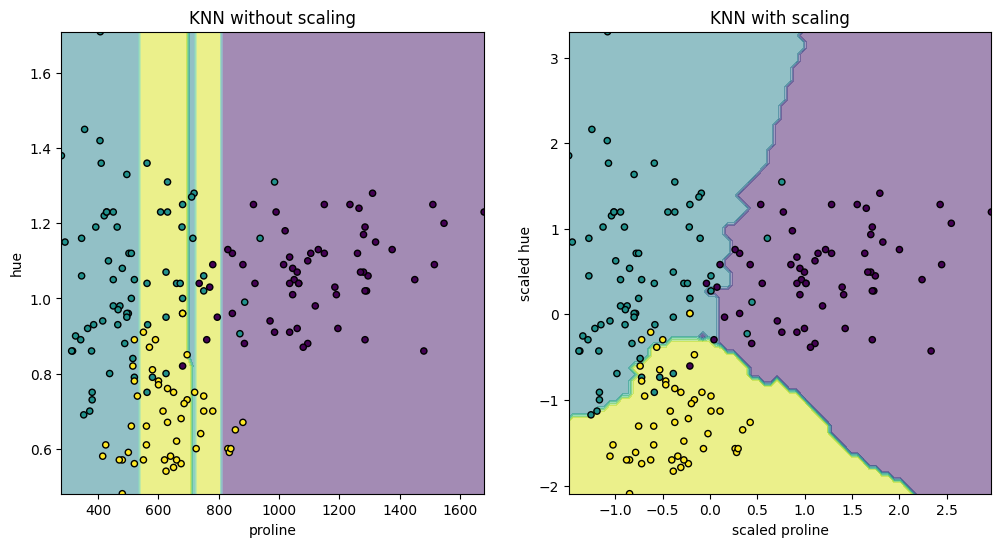

In [3]:
import matplotlib.pyplot as plt

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

X_plot = X[["proline", "hue"]]
X_plot_scaled = scaler.fit_transform(X_plot)
clf = KNeighborsClassifier(n_neighbors=20)


def fit_and_plot_model(X_plot, y, clf, ax):
    clf.fit(X_plot, y)
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X_plot,
        response_method="predict",
        alpha=0.5,
        ax=ax,
    )
    disp.ax_.scatter(X_plot["proline"], X_plot["hue"], c=y, s=20, edgecolor="k")
    disp.ax_.set_xlim((X_plot["proline"].min(), X_plot["proline"].max()))
    disp.ax_.set_ylim((X_plot["hue"].min(), X_plot["hue"].max()))
    return disp.ax_


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fit_and_plot_model(X_plot, y, clf, ax1)
ax1.set_title("KNN without scaling")

fit_and_plot_model(X_plot_scaled, y, clf, ax2)
ax2.set_xlabel("scaled proline")
ax2.set_ylabel("scaled hue")
_ = ax2.set_title("KNN with scaling")

Here the decision boundary shows that fitting scaled or non-scaled data lead
to completely different models. The reason is that the variable "proline" has
values which vary between 0 and 1,000; whereas the variable "hue" varies
between 1 and 10. Because of this, distances between samples are mostly
impacted by differences in values of "proline", while values of the "hue" will
be comparatively ignored. If one uses
:class:`~sklearn.preprocessing.StandardScaler` to normalize this database,
both scaled values lay approximately between -3 and 3 and the neighbors
structure will be impacted more or less equivalently by both variables.

## Effect of rescaling on a PCA dimensional reduction

Dimensional reduction using :class:`~sklearn.decomposition.PCA` consists of
finding the features that maximize the variance. If one feature varies more
than the others only because of their respective scales,
:class:`~sklearn.decomposition.PCA` would determine that such feature
dominates the direction of the principal components.

We can inspect the first principal components using all the original features:



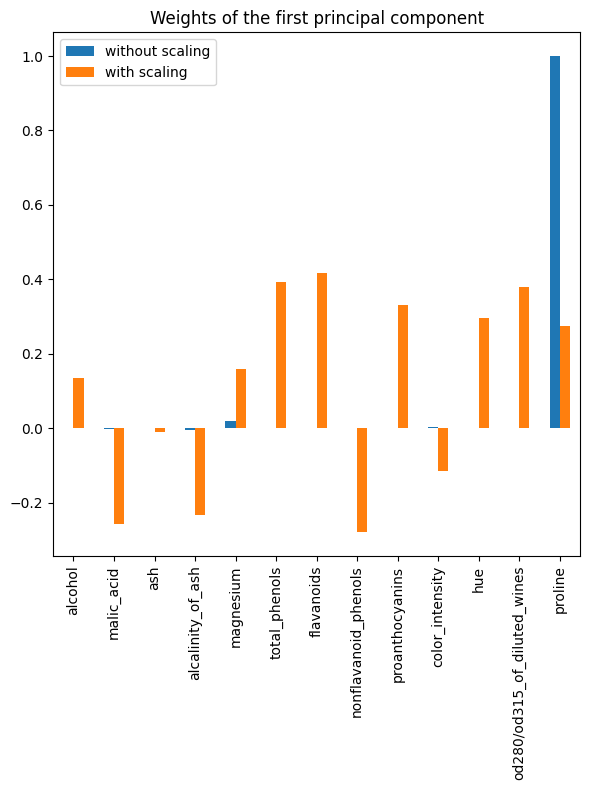

In [4]:
import pandas as pd

from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit(X_train)
scaled_pca = PCA(n_components=2).fit(scaled_X_train)
X_train_transformed = pca.transform(X_train)
X_train_std_transformed = scaled_pca.transform(scaled_X_train)

first_pca_component = pd.DataFrame(
    pca.components_[0], index=X.columns, columns=["without scaling"]
)
first_pca_component["with scaling"] = scaled_pca.components_[0]
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(6, 8)
)

_ = plt.tight_layout()

Indeed we find that the "proline" feature dominates the direction of the first
principal component without scaling, being about two orders of magnitude above
the other features. This is contrasted when observing the first principal
component for the scaled version of the data, where the orders of magnitude
are roughly the same across all the features.

We can visualize the distribution of the principal components in both cases:



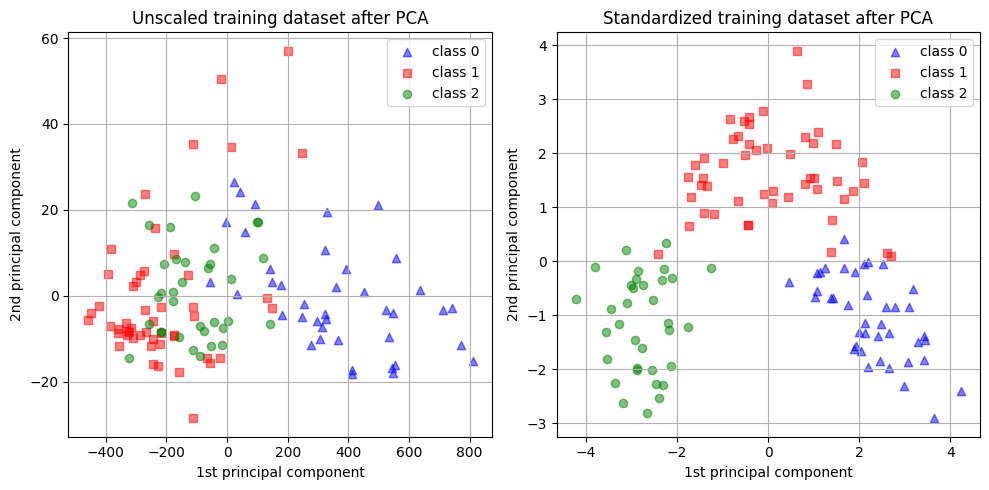

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

target_classes = range(0, 3)
colors = ("blue", "red", "green")
markers = ("^", "s", "o")

for target_class, color, marker in zip(target_classes, colors, markers):
    ax1.scatter(
        x=X_train_transformed[y_train == target_class, 0],
        y=X_train_transformed[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5,
        marker=marker,
    )

    ax2.scatter(
        x=X_train_std_transformed[y_train == target_class, 0],
        y=X_train_std_transformed[y_train == target_class, 1],
        color=color,
        label=f"class {target_class}",
        alpha=0.5,
        marker=marker,
    )

ax1.set_title("Unscaled training dataset after PCA")
ax2.set_title("Standardized training dataset after PCA")

for ax in (ax1, ax2):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()

_ = plt.tight_layout()

From the plot above we observe that scaling the features before reducing the
dimensionality results in components with the same order of magnitude. In this
case it also improves the separability of the classes. Indeed, in the next
section we confirm that a better separability has a good repercussion on the
overall model's performance.

## Effect of rescaling on model's performance

First we show how the optimal regularization of a
:class:`~sklearn.linear_model.LogisticRegressionCV` depends on the scaling or
non-scaling of the data:



In [6]:
import numpy as np

from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

Cs = np.logspace(-5, 5, 20)

unscaled_clf = make_pipeline(pca, LogisticRegressionCV(Cs=Cs))
unscaled_clf.fit(X_train, y_train)

scaled_clf = make_pipeline(scaler, pca, LogisticRegressionCV(Cs=Cs))
scaled_clf.fit(X_train, y_train)

print(f"Optimal C for the unscaled PCA: {unscaled_clf[-1].C_[0]:.4f}\n")
print(f"Optimal C for the standardized data with PCA: {scaled_clf[-1].C_[0]:.2f}")

Optimal C for the unscaled PCA: 0.0004

Optimal C for the standardized data with PCA: 20.69


The need for regularization is higher (lower values of `C`) for the data that
was not scaled before applying PCA. We now evaluate the effect of scaling on
the accuracy and the mean log-loss of the optimal models:



In [7]:
from sklearn.metrics import accuracy_score, log_loss

y_pred = unscaled_clf.predict(X_test)
y_pred_scaled = scaled_clf.predict(X_test)
y_proba = unscaled_clf.predict_proba(X_test)
y_proba_scaled = scaled_clf.predict_proba(X_test)

print("Test accuracy for the unscaled PCA")
print(f"{accuracy_score(y_test, y_pred):.2%}\n")
print("Test accuracy for the standardized data with PCA")
print(f"{accuracy_score(y_test, y_pred_scaled):.2%}\n")
print("Log-loss for the unscaled PCA")
print(f"{log_loss(y_test, y_proba):.3}\n")
print("Log-loss for the standardized data with PCA")
print(f"{log_loss(y_test, y_proba_scaled):.3}")

Test accuracy for the unscaled PCA
35.19%

Test accuracy for the standardized data with PCA
96.30%

Log-loss for the unscaled PCA
2.07

Log-loss for the standardized data with PCA
0.0824


A clear difference in prediction accuracies is observed when the data is
scaled before :class:`~sklearn.decomposition.PCA`, as it vastly outperforms
the unscaled version. This corresponds to the intuition obtained from the plot
in the previous section, where the components become linearly separable when
scaling before using :class:`~sklearn.decomposition.PCA`.

Notice that in this case the models with scaled features perform better than
the models with non-scaled features because all the variables are expected to
be predictive and we rather avoid some of them being comparatively ignored.

If the variables in lower scales were not predictive, one may experience a
decrease of the performance after scaling the features: noisy features would
contribute more to the prediction after scaling and therefore scaling would
increase overfitting.

Last but not least, we observe that one achieves a lower log-loss by means of
the scaling step.

